In [1]:
import numpy as np
import gdal
import ogr
from skimage import exposure
from skimage.segmentation import quickshift
from skimage.segmentation import felzenszwalb
import geopandas as gpd
import numpy as np
import scipy
import time
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from PIL import Image
from IPython.display import Image

In [2]:
image = "wellington.tif"
segments_fn = "segments.tif"

In [3]:
driverTiff = gdal.GetDriverByName('GTiff')
naip_ds = gdal.Open(image)
nbands = naip_ds.RasterCount
band_data = []
print("bands", naip_ds.RasterCount, 'rows', naip_ds.RasterYSize, 'columns', naip_ds.RasterXSize)

for i in range(1, nbands+1):
    band = naip_ds.GetRasterBand(i).ReadAsArray()
    band_data.append(band)
band_data = np.dstack(band_data)
print(band_data.shape)

bands 4 rows 1782 columns 3100
(1782, 3100, 4)


In [4]:
img = exposure.rescale_intensity(band_data)

In [5]:

segments = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)

C:\Windows\Anaconda3-2020.02\envs\g420\lib\site-packages\IPython\core\interactiveshell.py:3418: RuntimeWarning: Got image with third dimension of 4. This image will be interpreted as a multichannel 2d image, which may not be intended.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
np.unique(segments).shape

(9111,)

In [7]:
#ID for each segement

def segment_features(segment_pixels):
    features = []
    npixels, nbands = segment_pixels.shape
    
    for b in range(nbands):
        stats = scipy.stats.describe(segment_pixels[:, b])
        band_stats = list(stats.minmax) + list(stats)[2:]
        if npixels == 1:
            # in this case the variance = nan, change it 0.0
            band_stats[3] = 0.0
        features += band_stats
    return features

In [8]:
segment_ids = np.unique(segments)
objects = []
object_ids = []
for id in segment_ids:
    segment_pixels = img[segments == id]
    object_features = segment_features(segment_pixels)
    objects.append(object_features)
    object_ids.append(id)

Create a raster 

In [9]:
segments_fn = 'segments_final.tif'

segments_ds = driverTiff.Create(segments_fn, naip_ds.RasterXSize, naip_ds.RasterYSize,
                                1, gdal.GDT_Float32)
segments_ds.SetGeoTransform(naip_ds.GetGeoTransform())
segments_ds.SetProjection(naip_ds.GetProjectionRef())
segments_ds.GetRasterBand(1).WriteArray(segments)
segments_ds = None


In [10]:
nrows = naip_ds.RasterYSize
ncols = naip_ds.RasterXSize


gdf = gpd.read_file('truth_data2.shp')
class_names = gdf['LCtype'].unique()
print('class names', class_names)
class_ids = np.arange(class_names.size) + 1
print('class ids', class_ids)

df = pd.DataFrame({'label': class_names, 'id': class_ids})
df.to_csv('class_lookup.csv')


gdf['id'] = gdf['LCtype'].map(dict(zip(class_names, class_ids)))
print('gdf with ids', gdf.head())


# split the truth data into training and test data sets and save each to a new shapefile
gdf_train = gdf.sample(frac=0.7)  # 70% of observations assigned to training data (30% to test data)
gdf_test = gdf.drop(gdf_train.index)

print('gdf shape', gdf.shape, 'training shape', gdf_train.shape, 'test. gdf_test.shape')

gdf_train.to_file('train_data.shp')
gdf_test.to_file('test_data.shp')


class names ['Water' 'Grass' 'Vegetation' 'Concrete' 'Building']
class ids [1 2 3 4 5]
gdf with ids   LCtype                         geometry  id
0  Water  POINT (1749001.117 5427878.747)   1
1  Water  POINT (1749012.782 5427904.145)   1
2  Water  POINT (1749035.922 5427880.628)   1
3  Water  POINT (1749066.022 5427863.885)   1
4  Water  POINT (1749008.831 5427838.111)   1
gdf shape (337, 3) training shape (236, 3) test. gdf_test.shape


In [11]:
train_fn = 'train_data.shp'
train_ds = ogr.Open(train_fn)
lyr = train_ds.GetLayer()

# create a new raster layer in memory
driver = gdal.GetDriverByName('MEM')
target_ds = driver.Create('', naip_ds.RasterXSize, naip_ds.RasterYSize, 1, gdal.GDT_UInt16)
target_ds.SetGeoTransform(naip_ds.GetGeoTransform())
target_ds.SetProjection(naip_ds.GetProjection())

# rasterize the training points
options = ['ATTRIBUTE=id']
gdal.RasterizeLayer(target_ds, [1], lyr, options=options)

# retrieve the rasterized data and print basic stats
data = target_ds.GetRasterBand(1).ReadAsArray()
print('min', data.min(), 'max', data.max(), 'mean', data.mean())


min 0 max 5 mean 0.00015948010571666484


In [12]:
# rasterized observation (truth, training and test) data
ground_truth = target_ds.GetRasterBand(1).ReadAsArray()

# get unique values (0 is the background, or no data, value so it is not included) for each land cover type
classes = np.unique(ground_truth)[1:]
print('class values', classes)


# for each class (land cover type) record the associated segment IDs
segments_per_class = {}

for klass in classes:
    segments_of_class = segments[ground_truth == klass]
    segments_per_class[klass] = set(segments_of_class)
    print("Training segments for class", klass, ":", len(segments_of_class))
    
    
# make sure no segment ID represents more than one class
intersection = set()
accum = set()

for class_segments in segments_per_class.values():
    intersection |= accum.intersection(class_segments)
    accum |= class_segments
assert len(intersection) == 0, "Segment(s) represent multiple classes"




class values [1 2 3 4 5]
Training segments for class 1 : 27
Training segments for class 2 : 28
Training segments for class 3 : 22
Training segments for class 4 : 63
Training segments for class 5 : 96


In [13]:
train_img = np.copy(segments)
threshold = train_img.max() + 1  # make the threshold value greater than any land cover class value


# all pixels in training segments assigned value greater than threshold
for klass in classes:
    class_label = threshold + klass
    for segment_id in segments_per_class[klass]:
        train_img[train_img == segment_id] = class_label

# training segments receive land cover class value, all other segments 0
train_img[train_img <= threshold] = 0
train_img[train_img > threshold] -= threshold
        
# create objects and labels for training data
training_objects = []
training_labels = []
for klass in classes:
    class_train_object = [v for i, v in enumerate(objects) if segment_ids[i] in segments_per_class[klass]]
    training_labels += [klass] * len(class_train_object)
    training_objects += class_train_object
        

classifier = RandomForestClassifier(n_jobs=-1)  # setup random forest classifier
classifier.fit(training_objects, training_labels)  # fit rf classifier
print('Fitting Random Forest Classifier')
predicted = classifier.predict(objects)  # predict with rf classifier
print('Predicting Classifications')


# create numpy array from rf classifiation and save to raster
clf = np.copy(segments)
for segment_id, klass in zip(segment_ids, predicted):
    clf[clf == segment_id] = klass
    
print('Prediction applied to')
    
mask = np.sum(img, axis=2)  # this section masks no data values
mask[mask > 0.0] = 1.0
mask[mask == 0.0] = -1.0
clf = np.multiply(clf, mask)
clf[clf < 0] = -9999.0

print('Saving class classification to raster')

clfds = driverTiff.Create('classified_result1.tif', naip_ds.RasterXSize, naip_ds.RasterYSize,
                          1, gdal.GDT_Float32)  # this section saves to raster
clfds.SetGeoTransform(naip_ds.GetGeoTransform())
clfds.SetProjection(naip_ds.GetProjection())
clfds.GetRasterBand(1).SetNoDataValue(-9999.0)
clfds.GetRasterBand(1).WriteArray(clf)
clfds = None

print('Done')
        
        
        
        
        


Fitting Random Forest Classifier
Predicting Classifications
Prediction applied to
Saving class classification to raster
Done


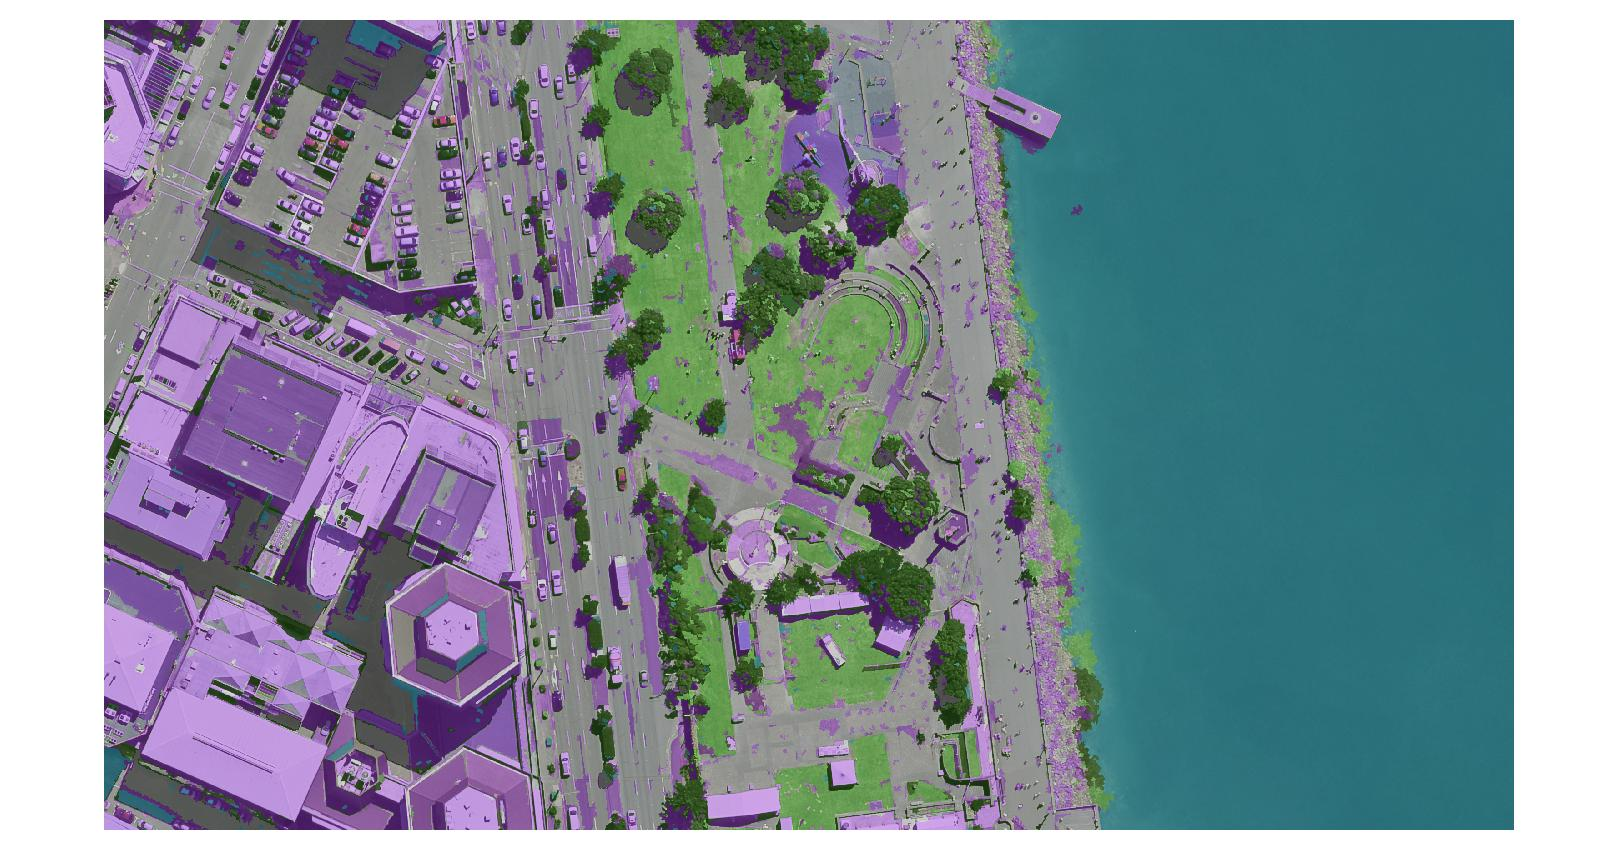

In [14]:
Image(filename='Felzenszwalb.JPG') 